H&E to IF Marker Pattern Analysis
This analysis will identify:
• Spatial distribution of DAPI, CD8, and CD163 markers
• Colocalization patterns between markers
• Correlation with H&E morphological features
• Regional variations in marker expression
• Immune activity hotspots
• Statistical relationships for model training insights

H&E TO IF MARKER PATTERN ANALYSIS
Loading H&E image: warped_source.tiff
  Attempting to load warped_source.tiff...
    Trying tifffile...
    ❌ tifffile failed: incompatible keyframe
    Trying PIL...
      Multi-page TIFF detected: 10 pages
      Resizing from (30720, 46080) to (5773, 8660) for analysis


    ✅ Loaded with PIL: (8660, 5773, 3), uint8
Loading IF image: target.tiff
  Attempting to load target.tiff...
    Trying tifffile...
    Converted from CHW to HWC format
    ✅ Loaded with tifffile: (46080, 30720, 3), uint16
Resizing images to match: H&E (8660, 5773) -> IF (46080, 30720)
Images loaded successfully:
  H&E shape: (8660, 5773, 3)
  IF shape: (8660, 5773, 3)
  DAPI range: 0 - 4936
  CD8 range: 0 - 2051
  CD163 range: 0 - 2582
Enhancing marker contrast using (1, 99.5) percentiles...
  DAPI: 2.0-802.0 -> 0-65535.0
  CD8: 1.0-176.0 -> 0-65535.0
  CD163: 1.0-134.0 -> 0-65535.0
Creating comprehensive visualization...
Analyzing spatial patterns using 15x15 grid...
  Created 225 regional measurements
  Average DAPI intensity: 6446.84
  Average CD8 intensity: 7539.98
  Average CD163 intensity: 2349.03
Analyzing marker colocalization (>95th percentile)...
  DAPI_positive_pct: 3.76%
  CD8_positive_pct: 3.61%
  CD163_positive_pct: 2.90%
  CD8_CD163_overlap_pct: 0.65%
  CD8_in_DAPI_p

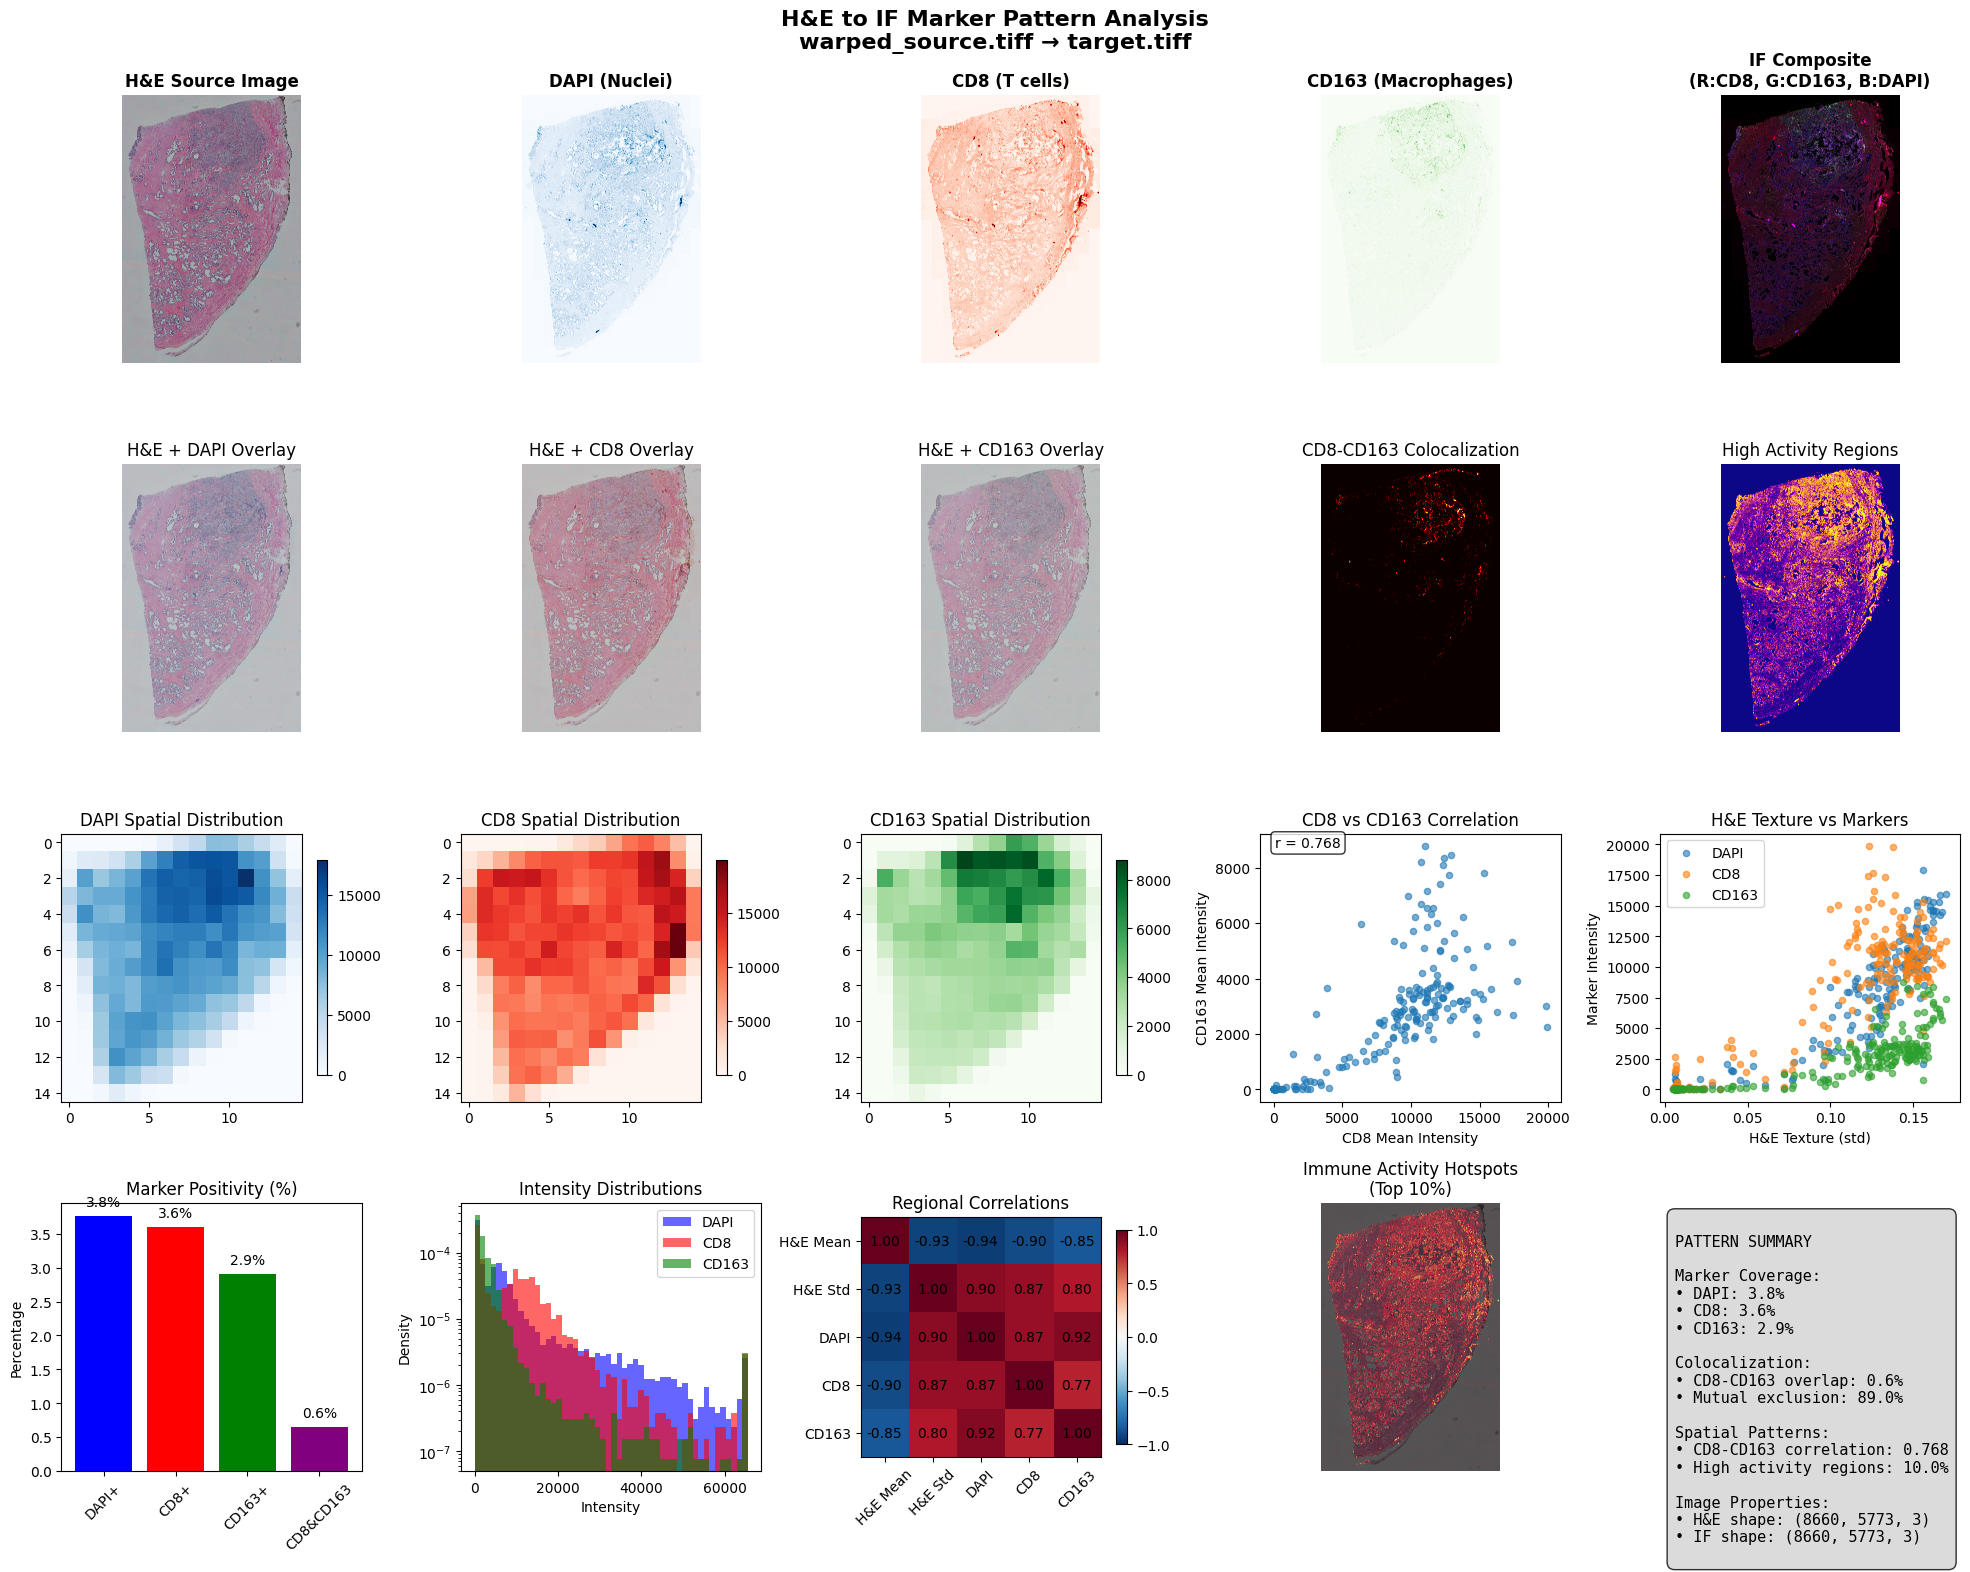

Regional statistics saved: he_if_pattern_analysis/regional_statistics_warped_source_to_target.csv
Colocalization statistics saved: he_if_pattern_analysis/colocalization_stats_warped_source_to_target.txt

ANALYSIS COMPLETE!
Key findings:
• DAPI coverage: 3.8% (nuclei density)
• CD8+ T cells: 3.6% (cytotoxic immune response)
• CD163+ macrophages: 2.9% (tumor-associated macrophages)
• CD8-CD163 overlap: 0.6% (immune interaction zones)
• Strong positive correlation (r=0.768) suggests coordinated immune response

Files generated:
• Comprehensive visualization (PNG)
• Regional statistics (CSV)
• Colocalization summary (TXT)

INTERPRETATION GUIDE
DAPI (Blue): Nuclear stain - indicates cell density
CD8 (Red): Cytotoxic T lymphocytes - anti-tumor immune cells
CD163 (Green): M2 macrophages - often tumor-promoting

Pattern Insights for Model Training:
• High DAPI + High CD8 = Active immune response regions
• High CD163 + Low CD8 = Immunosuppressive regions
• CD8-CD163 overlap = Immune interaction

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from pathlib import Path
from skimage import exposure, filters, segmentation, measure, morphology
from skimage.color import rgb2gray
from scipy import ndimage
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
from typing import Tuple, Dict, List
import warnings
warnings.filterwarnings('ignore')

class HEIFPatternAnalyzer:
    """
    Analyze spatial patterns between H&E morphology and IF marker expression.
    """
    
    def __init__(self, he_image_path: str, if_image_path: str):
        """
        Initialize analyzer with H&E and IF image paths.
        
        Args:
            he_image_path: Path to H&E source image
            if_image_path: Path to IF target image (3 channels: DAPI, CD8, CD163)
        """
        self.he_path = Path(he_image_path)
        self.if_path = Path(if_image_path)
        
        # Load images
        print(f"Loading H&E image: {self.he_path.name}")
        self.he_image = self._load_image(he_image_path)
        
        print(f"Loading IF image: {self.if_path.name}")
        self.if_image = self._load_image(if_image_path)
        
        # Ensure images are the same size
        self._resize_to_match()
        
        # Extract individual marker channels
        self.dapi_channel = self.if_image[:, :, 0]  # Channel 0: DAPI (nuclei)
        self.cd8_channel = self.if_image[:, :, 1]   # Channel 1: CD8 (T cells)
        self.cd163_channel = self.if_image[:, :, 2] # Channel 2: CD163 (macrophages)
        
        # Convert H&E to grayscale for analysis
        self.he_gray = rgb2gray(self.he_image) if len(self.he_image.shape) == 3 else self.he_image
        
        print(f"Images loaded successfully:")
        print(f"  H&E shape: {self.he_image.shape}")
        print(f"  IF shape: {self.if_image.shape}")
        print(f"  DAPI range: {self.dapi_channel.min():.0f} - {self.dapi_channel.max():.0f}")
        print(f"  CD8 range: {self.cd8_channel.min():.0f} - {self.cd8_channel.max():.0f}")
        print(f"  CD163 range: {self.cd163_channel.min():.0f} - {self.cd163_channel.max():.0f}")
    
    def _load_image(self, image_path: str) -> np.ndarray:
        """Load image with multiple fallback methods for problematic TIFFs."""
        filepath = str(image_path)
        filename = Path(filepath).name
        
        print(f"  Attempting to load {filename}...")
        
        # Method 1: Try tifffile (best for scientific TIFFs)
        try:
            print(f"    Trying tifffile...")
            with tifffile.TiffFile(filepath) as tif:
                image = tif.asarray()
                
                # Handle different channel arrangements
                if len(image.shape) == 3:
                    if image.shape[0] <= 10:  # (C, H, W) format
                        image = np.transpose(image, (1, 2, 0))  # Convert to (H, W, C)
                        print(f"    Converted from CHW to HWC format")
                
                print(f"    ✅ Loaded with tifffile: {image.shape}, {image.dtype}")
                return image
        except Exception as e:
            print(f"    ❌ tifffile failed: {e}")
        
        # Method 2: Try PIL with increased limits
        try:
            print(f"    Trying PIL...")
            from PIL import Image
            
            # Temporarily increase PIL's size limits
            original_max_pixels = Image.MAX_IMAGE_PIXELS
            Image.MAX_IMAGE_PIXELS = None  # Remove limit entirely
            
            try:
                with Image.open(filepath) as img:
                    # Handle multi-page TIFFs
                    if hasattr(img, 'n_frames') and img.n_frames > 1:
                        print(f"      Multi-page TIFF detected: {img.n_frames} pages")
                        img.seek(0)  # Go to first page
                    
                    # For very large images, resize to manageable size
                    original_size = img.size
                    total_pixels = original_size[0] * original_size[1]
                    
                    if total_pixels > 100_000_000:  # >100M pixels
                        target_pixels = 50_000_000  # 50M pixels target
                        scale_factor = (target_pixels / total_pixels) ** 0.5
                        new_size = (int(original_size[0] * scale_factor), 
                                   int(original_size[1] * scale_factor))
                        print(f"      Resizing from {original_size} to {new_size} for analysis")
                        img = img.resize(new_size, Image.Resampling.LANCZOS)
                    
                    image = np.array(img)
                    print(f"    ✅ Loaded with PIL: {image.shape}, {image.dtype}")
                    return image
            finally:
                # Restore original limit
                Image.MAX_IMAGE_PIXELS = original_max_pixels
                
        except Exception as e:
            print(f"    ❌ PIL failed: {e}")
        
        # Method 3: Try OpenCV
        try:
            print(f"    Trying OpenCV...")
            import cv2
            import os
            
            # Override OpenCV's pixel limit
            original_env = os.environ.get('OPENCV_IO_MAX_IMAGE_PIXELS', None)
            os.environ['OPENCV_IO_MAX_IMAGE_PIXELS'] = str(2**31-1)
            
            try:
                image = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
                if image is not None:
                    # OpenCV loads as BGR, convert to RGB if 3 channels
                    if len(image.shape) == 3 and image.shape[2] == 3:
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    print(f"    ✅ Loaded with OpenCV: {image.shape}, {image.dtype}")
                    return image
                else:
                    print(f"    ❌ OpenCV returned None")
            finally:
                # Restore original environment
                if original_env is not None:
                    os.environ['OPENCV_IO_MAX_IMAGE_PIXELS'] = original_env
                else:
                    os.environ.pop('OPENCV_IO_MAX_IMAGE_PIXELS', None)
                    
        except Exception as e:
            print(f"    ❌ OpenCV failed: {e}")
        
        # Method 4: Try imageio
        try:
            print(f"    Trying imageio...")
            import imageio.v2 as imageio
            
            image = imageio.imread(filepath)
            print(f"    ✅ Loaded with imageio: {image.shape}, {image.dtype}")
            return image
            
        except Exception as e:
            print(f"    ❌ imageio failed: {e}")
        
        # Method 5: Try reading specific page with tifffile
        try:
            print(f"    Trying tifffile page-by-page...")
            with tifffile.TiffFile(filepath) as tif:
                # Try reading individual pages
                for page_idx in range(min(3, len(tif.pages))):
                    try:
                        page = tif.pages[page_idx]
                        image = page.asarray()
                        
                        # Handle channel arrangements
                        if len(image.shape) == 3 and image.shape[0] <= 10:
                            image = np.transpose(image, (1, 2, 0))
                        
                        print(f"    ✅ Loaded page {page_idx} with tifffile: {image.shape}, {image.dtype}")
                        return image
                    except:
                        continue
        except Exception as e:
            print(f"    ❌ Page-by-page reading failed: {e}")
        
        # All methods failed
        print(f"    ❌ All loading methods failed for {filename}")
        raise RuntimeError(f"Could not load image {filename} with any available method")
    
    def _resize_to_match(self):
        """Ensure both images have the same dimensions."""
        he_shape = self.he_image.shape[:2]
        if_shape = self.if_image.shape[:2]
        
        if he_shape != if_shape:
            print(f"Resizing images to match: H&E {he_shape} -> IF {if_shape}")
            min_height = min(he_shape[0], if_shape[0])
            min_width = min(he_shape[1], if_shape[1])
            
            from skimage.transform import resize
            
            if len(self.he_image.shape) == 3:
                self.he_image = resize(self.he_image, (min_height, min_width, self.he_image.shape[2]), 
                                     preserve_range=True, anti_aliasing=True).astype(self.he_image.dtype)
            else:
                self.he_image = resize(self.he_image, (min_height, min_width), 
                                     preserve_range=True, anti_aliasing=True).astype(self.he_image.dtype)
            
            self.if_image = resize(self.if_image, (min_height, min_width, self.if_image.shape[2]), 
                                 preserve_range=True, anti_aliasing=True).astype(self.if_image.dtype)
    
    def enhance_markers(self, percentile_range=(1, 99.5)):
        """
        Enhance marker visibility using percentile-based contrast stretching.
        
        Args:
            percentile_range: Percentiles for contrast enhancement
        """
        print(f"Enhancing marker contrast using {percentile_range} percentiles...")
        
        for i, (channel, name) in enumerate([(self.dapi_channel, 'DAPI'), 
                                           (self.cd8_channel, 'CD8'), 
                                           (self.cd163_channel, 'CD163')]):
            if np.any(channel > 0):
                p_low, p_high = np.percentile(channel[channel > 0], percentile_range)
                enhanced = exposure.rescale_intensity(channel, in_range=(p_low, p_high))
                
                if i == 0:
                    self.dapi_channel = enhanced
                elif i == 1:
                    self.cd8_channel = enhanced
                else:
                    self.cd163_channel = enhanced
                
                print(f"  {name}: {p_low:.1f}-{p_high:.1f} -> 0-{enhanced.max():.1f}")
    
    def segment_tissue_regions(self, he_threshold=0.1, min_area=1000):
        """
        Segment tissue regions from background in H&E image.
        
        Args:
            he_threshold: Threshold for tissue vs background
            min_area: Minimum area for tissue regions
        
        Returns:
            Binary mask of tissue regions
        """
        print("Segmenting tissue regions...")
        
        # Simple threshold-based segmentation
        tissue_mask = self.he_gray > he_threshold
        
        # Remove small objects
        tissue_mask = morphology.remove_small_objects(tissue_mask, min_size=min_area)
        
        # Fill holes
        tissue_mask = ndimage.binary_fill_holes(tissue_mask)
        
        tissue_percentage = np.sum(tissue_mask) / tissue_mask.size * 100
        print(f"  Tissue coverage: {tissue_percentage:.1f}%")
        
        return tissue_mask
    
    def analyze_marker_colocalization(self, threshold_percentile=95):
        """
        Analyze spatial relationships between different markers.
        
        Args:
            threshold_percentile: Percentile threshold for positive staining
        
        Returns:
            Dictionary with colocalization statistics
        """
        print(f"Analyzing marker colocalization (>{threshold_percentile}th percentile)...")
        
        # Define positive staining thresholds
        dapi_thresh = np.percentile(self.dapi_channel[self.dapi_channel > 0], threshold_percentile)
        cd8_thresh = np.percentile(self.cd8_channel[self.cd8_channel > 0], threshold_percentile)
        cd163_thresh = np.percentile(self.cd163_channel[self.cd163_channel > 0], threshold_percentile)
        
        # Create binary masks for positive staining
        dapi_positive = self.dapi_channel > dapi_thresh
        cd8_positive = self.cd8_channel > cd8_thresh
        cd163_positive = self.cd163_channel > cd163_thresh
        
        # Calculate colocalization
        total_pixels = dapi_positive.size
        
        colocalization = {
            'DAPI_positive_pct': np.sum(dapi_positive) / total_pixels * 100,
            'CD8_positive_pct': np.sum(cd8_positive) / total_pixels * 100,
            'CD163_positive_pct': np.sum(cd163_positive) / total_pixels * 100,
            'CD8_CD163_overlap_pct': np.sum(cd8_positive & cd163_positive) / total_pixels * 100,
            'CD8_in_DAPI_pct': np.sum(cd8_positive & dapi_positive) / np.sum(dapi_positive) * 100 if np.sum(dapi_positive) > 0 else 0,
            'CD163_in_DAPI_pct': np.sum(cd163_positive & dapi_positive) / np.sum(dapi_positive) * 100 if np.sum(dapi_positive) > 0 else 0,
        }
        
        # Mutual exclusivity analysis
        colocalization['CD8_CD163_mutual_exclusion'] = (
            np.sum(cd8_positive & ~cd163_positive) + np.sum(cd163_positive & ~cd8_positive)
        ) / np.sum(cd8_positive | cd163_positive) * 100 if np.sum(cd8_positive | cd163_positive) > 0 else 0
        
        for key, value in colocalization.items():
            print(f"  {key}: {value:.2f}%")
        
        return colocalization
    
    def analyze_spatial_patterns(self, grid_size=20):
        """
        Analyze spatial patterns by dividing image into grid regions.
        
        Args:
            grid_size: Number of grid divisions per side
        
        Returns:
            DataFrame with regional statistics
        """
        print(f"Analyzing spatial patterns using {grid_size}x{grid_size} grid...")
        
        height, width = self.he_gray.shape
        grid_h = height // grid_size
        grid_w = width // grid_size
        
        regions = []
        
        for i in range(grid_size):
            for j in range(grid_size):
                # Define grid boundaries
                y1, y2 = i * grid_h, min((i + 1) * grid_h, height)
                x1, x2 = j * grid_w, min((j + 1) * grid_w, width)
                
                # Extract region data
                he_region = self.he_gray[y1:y2, x1:x2]
                dapi_region = self.dapi_channel[y1:y2, x1:x2]
                cd8_region = self.cd8_channel[y1:y2, x1:x2]
                cd163_region = self.cd163_channel[y1:y2, x1:x2]
                
                # Calculate regional statistics
                region_stats = {
                    'grid_i': i,
                    'grid_j': j,
                    'x_center': (x1 + x2) / 2,
                    'y_center': (y1 + y2) / 2,
                    'he_mean': np.mean(he_region),
                    'he_std': np.std(he_region),
                    'dapi_mean': np.mean(dapi_region),
                    'dapi_max': np.max(dapi_region),
                    'cd8_mean': np.mean(cd8_region),
                    'cd8_max': np.max(cd8_region),
                    'cd163_mean': np.mean(cd163_region),
                    'cd163_max': np.max(cd163_region),
                    'dapi_cd8_corr': np.corrcoef(dapi_region.flatten(), cd8_region.flatten())[0,1] if np.std(dapi_region) > 0 and np.std(cd8_region) > 0 else 0,
                    'dapi_cd163_corr': np.corrcoef(dapi_region.flatten(), cd163_region.flatten())[0,1] if np.std(dapi_region) > 0 and np.std(cd163_region) > 0 else 0,
                    'cd8_cd163_corr': np.corrcoef(cd8_region.flatten(), cd163_region.flatten())[0,1] if np.std(cd8_region) > 0 and np.std(cd163_region) > 0 else 0,
                }
                
                regions.append(region_stats)
        
        df = pd.DataFrame(regions)
        
        print(f"  Created {len(df)} regional measurements")
        print(f"  Average DAPI intensity: {df['dapi_mean'].mean():.2f}")
        print(f"  Average CD8 intensity: {df['cd8_mean'].mean():.2f}")
        print(f"  Average CD163 intensity: {df['cd163_mean'].mean():.2f}")
        
        return df
    
    def create_comprehensive_visualization(self, save_path=None):
        """
        Create comprehensive visualization of all patterns.
        
        Args:
            save_path: Optional path to save the figure
        """
        print("Creating comprehensive visualization...")
        
        fig = plt.figure(figsize=(20, 16))
        
        # Row 1: Original images
        plt.subplot(4, 5, 1)
        plt.imshow(self.he_image)
        plt.title('H&E Source Image', fontsize=12, fontweight='bold')
        plt.axis('off')
        
        plt.subplot(4, 5, 2)
        plt.imshow(self.dapi_channel, cmap='Blues')
        plt.title('DAPI (Nuclei)', fontsize=12, fontweight='bold')
        plt.axis('off')
        
        plt.subplot(4, 5, 3)
        plt.imshow(self.cd8_channel, cmap='Reds')
        plt.title('CD8 (T cells)', fontsize=12, fontweight='bold')
        plt.axis('off')
        
        plt.subplot(4, 5, 4)
        plt.imshow(self.cd163_channel, cmap='Greens')
        plt.title('CD163 (Macrophages)', fontsize=12, fontweight='bold')
        plt.axis('off')
        
        # Composite IF image
        plt.subplot(4, 5, 5)
        # Create RGB composite
        composite = np.zeros((*self.dapi_channel.shape, 3))
        composite[:, :, 0] = self.cd8_channel / self.cd8_channel.max()  # Red: CD8
        composite[:, :, 1] = self.cd163_channel / self.cd163_channel.max()  # Green: CD163
        composite[:, :, 2] = self.dapi_channel / self.dapi_channel.max()  # Blue: DAPI
        plt.imshow(composite)
        plt.title('IF Composite\n(R:CD8, G:CD163, B:DAPI)', fontsize=12, fontweight='bold')
        plt.axis('off')
        
        # Row 2: Overlay visualizations
        plt.subplot(4, 5, 6)
        plt.imshow(self.he_image)
        plt.imshow(self.dapi_channel, alpha=0.3, cmap='Blues')
        plt.title('H&E + DAPI Overlay', fontsize=12)
        plt.axis('off')
        
        plt.subplot(4, 5, 7)
        plt.imshow(self.he_image)
        plt.imshow(self.cd8_channel, alpha=0.3, cmap='Reds')
        plt.title('H&E + CD8 Overlay', fontsize=12)
        plt.axis('off')
        
        plt.subplot(4, 5, 8)
        plt.imshow(self.he_image)
        plt.imshow(self.cd163_channel, alpha=0.3, cmap='Greens')
        plt.title('H&E + CD163 Overlay', fontsize=12)
        plt.axis('off')
        
        # Colocalization maps
        plt.subplot(4, 5, 9)
        cd8_thresh = np.percentile(self.cd8_channel[self.cd8_channel > 0], 95)
        cd163_thresh = np.percentile(self.cd163_channel[self.cd163_channel > 0], 95)
        overlap = (self.cd8_channel > cd8_thresh) & (self.cd163_channel > cd163_thresh)
        plt.imshow(overlap, cmap='hot')
        plt.title('CD8-CD163 Colocalization', fontsize=12)
        plt.axis('off')
        
        # High-intensity regions
        plt.subplot(4, 5, 10)
        high_activity = (self.dapi_channel > np.percentile(self.dapi_channel, 90)) | \
                       (self.cd8_channel > np.percentile(self.cd8_channel, 90)) | \
                       (self.cd163_channel > np.percentile(self.cd163_channel, 90))
        plt.imshow(high_activity, cmap='plasma')
        plt.title('High Activity Regions', fontsize=12)
        plt.axis('off')
        
        # Row 3: Spatial analysis
        regional_df = self.analyze_spatial_patterns(grid_size=15)
        
        plt.subplot(4, 5, 11)
        grid_dapi = regional_df.pivot(index='grid_i', columns='grid_j', values='dapi_mean')
        plt.imshow(grid_dapi, cmap='Blues', aspect='auto')
        plt.title('DAPI Spatial Distribution', fontsize=12)
        plt.colorbar(shrink=0.8)
        
        plt.subplot(4, 5, 12)
        grid_cd8 = regional_df.pivot(index='grid_i', columns='grid_j', values='cd8_mean')
        plt.imshow(grid_cd8, cmap='Reds', aspect='auto')
        plt.title('CD8 Spatial Distribution', fontsize=12)
        plt.colorbar(shrink=0.8)
        
        plt.subplot(4, 5, 13)
        grid_cd163 = regional_df.pivot(index='grid_i', columns='grid_j', values='cd163_mean')
        plt.imshow(grid_cd163, cmap='Greens', aspect='auto')
        plt.title('CD163 Spatial Distribution', fontsize=12)
        plt.colorbar(shrink=0.8)
        
        # Correlation analysis
        plt.subplot(4, 5, 14)
        plt.scatter(regional_df['cd8_mean'], regional_df['cd163_mean'], alpha=0.6, s=20)
        plt.xlabel('CD8 Mean Intensity')
        plt.ylabel('CD163 Mean Intensity')
        plt.title('CD8 vs CD163 Correlation', fontsize=12)
        
        correlation = np.corrcoef(regional_df['cd8_mean'], regional_df['cd163_mean'])[0,1]
        plt.text(0.05, 0.95, f'r = {correlation:.3f}', transform=plt.gca().transAxes, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        # H&E texture vs markers
        plt.subplot(4, 5, 15)
        plt.scatter(regional_df['he_std'], regional_df['dapi_mean'], alpha=0.6, s=20, label='DAPI')
        plt.scatter(regional_df['he_std'], regional_df['cd8_mean'], alpha=0.6, s=20, label='CD8')
        plt.scatter(regional_df['he_std'], regional_df['cd163_mean'], alpha=0.6, s=20, label='CD163')
        plt.xlabel('H&E Texture (std)')
        plt.ylabel('Marker Intensity')
        plt.title('H&E Texture vs Markers', fontsize=12)
        plt.legend()
        
        # Row 4: Statistical summaries
        plt.subplot(4, 5, 16)
        colocalization_stats = self.analyze_marker_colocalization()
        stats_names = ['DAPI+', 'CD8+', 'CD163+', 'CD8&CD163']
        stats_values = [colocalization_stats['DAPI_positive_pct'], 
                       colocalization_stats['CD8_positive_pct'],
                       colocalization_stats['CD163_positive_pct'],
                       colocalization_stats['CD8_CD163_overlap_pct']]
        
        bars = plt.bar(stats_names, stats_values, color=['blue', 'red', 'green', 'purple'])
        plt.title('Marker Positivity (%)', fontsize=12)
        plt.ylabel('Percentage')
        plt.xticks(rotation=45)
        
        # Add value labels on bars
        for bar, value in zip(bars, stats_values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{value:.1f}%', ha='center', va='bottom', fontsize=10)
        
        # Intensity distributions
        plt.subplot(4, 5, 17)
        intensities = [self.dapi_channel.flatten(), self.cd8_channel.flatten(), self.cd163_channel.flatten()]
        labels = ['DAPI', 'CD8', 'CD163']
        colors = ['blue', 'red', 'green']
        
        for intensity, label, color in zip(intensities, labels, colors):
            # Sample data for faster plotting
            sample_size = min(10000, len(intensity))
            sample_indices = np.random.choice(len(intensity), sample_size, replace=False)
            sample_data = intensity[sample_indices]
            plt.hist(sample_data, bins=50, alpha=0.6, label=label, color=color, density=True)
        
        plt.xlabel('Intensity')
        plt.ylabel('Density')
        plt.title('Intensity Distributions', fontsize=12)
        plt.legend()
        plt.yscale('log')
        
        # Correlation heatmap
        plt.subplot(4, 5, 18)
        correlation_data = regional_df[['he_mean', 'he_std', 'dapi_mean', 'cd8_mean', 'cd163_mean']].corr()
        im = plt.imshow(correlation_data, cmap='RdBu_r', vmin=-1, vmax=1)
        plt.colorbar(im, shrink=0.8)
        plt.title('Regional Correlations', fontsize=12)
        
        labels = ['H&E Mean', 'H&E Std', 'DAPI', 'CD8', 'CD163']
        plt.xticks(range(len(labels)), labels, rotation=45)
        plt.yticks(range(len(labels)), labels)
        
        # Add correlation values
        for i in range(len(labels)):
            for j in range(len(labels)):
                plt.text(j, i, f'{correlation_data.iloc[i,j]:.2f}', 
                        ha='center', va='center', fontsize=10)
        
        # Spatial hotspots
        plt.subplot(4, 5, 19)
        # Identify hotspots (top 10% of combined marker activity)
        combined_activity = self.dapi_channel + self.cd8_channel + self.cd163_channel
        hotspot_thresh = np.percentile(combined_activity, 90)
        hotspots = combined_activity > hotspot_thresh
        
        plt.imshow(self.he_image)
        plt.imshow(hotspots, alpha=0.5, cmap='hot')
        plt.title('Immune Activity Hotspots\n(Top 10%)', fontsize=12)
        plt.axis('off')
        
        # Summary statistics text
        plt.subplot(4, 5, 20)
        plt.axis('off')
        
        summary_text = f"""
PATTERN SUMMARY

Marker Coverage:
• DAPI: {colocalization_stats['DAPI_positive_pct']:.1f}%
• CD8: {colocalization_stats['CD8_positive_pct']:.1f}%  
• CD163: {colocalization_stats['CD163_positive_pct']:.1f}%

Colocalization:
• CD8-CD163 overlap: {colocalization_stats['CD8_CD163_overlap_pct']:.1f}%
• Mutual exclusion: {colocalization_stats['CD8_CD163_mutual_exclusion']:.1f}%

Spatial Patterns:
• CD8-CD163 correlation: {correlation:.3f}
• High activity regions: {np.sum(hotspots)/hotspots.size*100:.1f}%

Image Properties:
• H&E shape: {self.he_image.shape}
• IF shape: {self.if_image.shape}
        """
        
        plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes, 
                fontsize=11, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
        
        plt.suptitle(f'H&E to IF Marker Pattern Analysis\n{self.he_path.name} → {self.if_path.name}', 
                    fontsize=16, fontweight='bold', y=0.98)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"Visualization saved: {save_path}")
        
        plt.show()
        
        return regional_df, colocalization_stats

def analyze_he_if_patterns(he_image_path: str, if_image_path: str, output_dir: str = "pattern_analysis"):
    """
    Complete analysis workflow for H&E to IF marker patterns.
    
    Args:
        he_image_path: Path to H&E source image
        if_image_path: Path to IF target image
        output_dir: Directory to save results
    """
    
    print("="*80)
    print("H&E TO IF MARKER PATTERN ANALYSIS")
    print("="*80)
    
    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    # Initialize analyzer
    analyzer = HEIFPatternAnalyzer(he_image_path, if_image_path)
    
    # Enhance marker visibility
    analyzer.enhance_markers()
    
    # Create comprehensive visualization
    save_path = output_path / f"pattern_analysis_{analyzer.he_path.stem}_to_{analyzer.if_path.stem}.png"
    regional_df, colocalization_stats = analyzer.create_comprehensive_visualization(save_path=save_path)
    
    # Save detailed statistics
    stats_path = output_path / f"regional_statistics_{analyzer.he_path.stem}_to_{analyzer.if_path.stem}.csv"
    regional_df.to_csv(stats_path, index=False)
    print(f"Regional statistics saved: {stats_path}")
    
    # Save colocalization results
    coloc_path = output_path / f"colocalization_stats_{analyzer.he_path.stem}_to_{analyzer.if_path.stem}.txt"
    with open(coloc_path, 'w') as f:
        f.write("COLOCALIZATION STATISTICS\n")
        f.write("="*40 + "\n\n")
        for key, value in colocalization_stats.items():
            f.write(f"{key}: {value:.3f}%\n")
    
    print(f"Colocalization statistics saved: {coloc_path}")
    
    return analyzer, regional_df, colocalization_stats

# Example usage
if __name__ == "__main__":
    
    # Update these paths to your actual image files
    he_image_path = "RegWSI_Pass1/Pair6/warped_source.tiff"  # H&E source image
    if_image_path = "RegWSI_Pass1/Pair6/target.tiff"         # IF target image with 3 channels
    
    print("H&E to IF Marker Pattern Analysis")
    print("=" * 50)
    print("This analysis will identify:")
    print("• Spatial distribution of DAPI, CD8, and CD163 markers")
    print("• Colocalization patterns between markers")
    print("• Correlation with H&E morphological features")
    print("• Regional variations in marker expression")
    print("• Immune activity hotspots")
    print("• Statistical relationships for model training insights")
    print()
    
    try:
        analyzer, regional_df, coloc_stats = analyze_he_if_patterns(
            he_image_path=he_image_path,
            if_image_path=if_image_path,
            output_dir="he_if_pattern_analysis"
        )
        
        print("\n" + "="*60)
        print("ANALYSIS COMPLETE!")
        print("="*60)
        print("Key findings:")
        print(f"• DAPI coverage: {coloc_stats['DAPI_positive_pct']:.1f}% (nuclei density)")
        print(f"• CD8+ T cells: {coloc_stats['CD8_positive_pct']:.1f}% (cytotoxic immune response)")
        print(f"• CD163+ macrophages: {coloc_stats['CD163_positive_pct']:.1f}% (tumor-associated macrophages)")
        print(f"• CD8-CD163 overlap: {coloc_stats['CD8_CD163_overlap_pct']:.1f}% (immune interaction zones)")
        
        correlation = np.corrcoef(regional_df['cd8_mean'], regional_df['cd163_mean'])[0,1]
        if correlation > 0.3:
            print(f"• Strong positive correlation (r={correlation:.3f}) suggests coordinated immune response")
        elif correlation < -0.3:
            print(f"• Strong negative correlation (r={correlation:.3f}) suggests competitive/exclusive patterns")
        else:
            print(f"• Weak correlation (r={correlation:.3f}) suggests independent marker patterns")
        
        print("\nFiles generated:")
        print("• Comprehensive visualization (PNG)")
        print("• Regional statistics (CSV)")
        print("• Colocalization summary (TXT)")
        
    except Exception as e:
        print(f"Analysis failed: {e}")
        import traceback
        traceback.print_exc()
    
    print("\n" + "="*60)
    print("INTERPRETATION GUIDE")
    print("="*60)
    print("DAPI (Blue): Nuclear stain - indicates cell density")
    print("CD8 (Red): Cytotoxic T lymphocytes - anti-tumor immune cells")
    print("CD163 (Green): M2 macrophages - often tumor-promoting")
    print("\nPattern Insights for Model Training:")
    print("• High DAPI + High CD8 = Active immune response regions")
    print("• High CD163 + Low CD8 = Immunosuppressive regions")
    print("• CD8-CD163 overlap = Immune interaction zones")
    print("• Spatial clustering = Organized immune structures")
    print("• H&E texture correlation = Morphology-function relationships")